In [22]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm

from vax_sims_LHS_samples import *
from plot_utils import *
# from util_functions import *
# from uncertainty_analysis import *
# from sim_helper_functions import *

In [23]:
def load_sim_output(folder, npoints, lb=0):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(lb, npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        new_row['cornell_inf_10'] = np.quantile(student_infxns + staff_infxns, 0.1)
        new_row['cornell_inf_50'] = np.quantile(student_infxns + staff_infxns, 0.5)
        new_row['cornell_inf_90'] = np.quantile(student_infxns + staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

def residential_regression_student(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'student_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results

def residential_regression_staff(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'staff_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results


In [3]:
def calculate_pessimistic_scenario(results, q=0.99, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']

    invquantile = norm.ppf(q)

    for param in params:
        sd_dict[param] = (UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*beta)
        centre_infections += np.mean(UNCERTAINTY_PARAM_RANGES[param]) * lr_results[param]

    sum_squares_Sigma_1 = 0

    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2

    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)

    mp_pess_scenario = dict()
    for param in params:
        mp_pess_scenario[param] = np.mean(UNCERTAINTY_PARAM_RANGES[param]) + invquantile * pess_direction[param]

    return mp_pess_scenario

In [4]:
LHS_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630458074.2074487', 200)

In [5]:
lr_results = residential_regression_student(LHS_data)
pess_scenario_student = calculate_pessimistic_scenario(lr_results)

In [6]:
def normalize_param(param_name, value):
    lower_bound = UNCERTAINTY_PARAM_RANGES[param_name][0]
    upper_bound = UNCERTAINTY_PARAM_RANGES[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

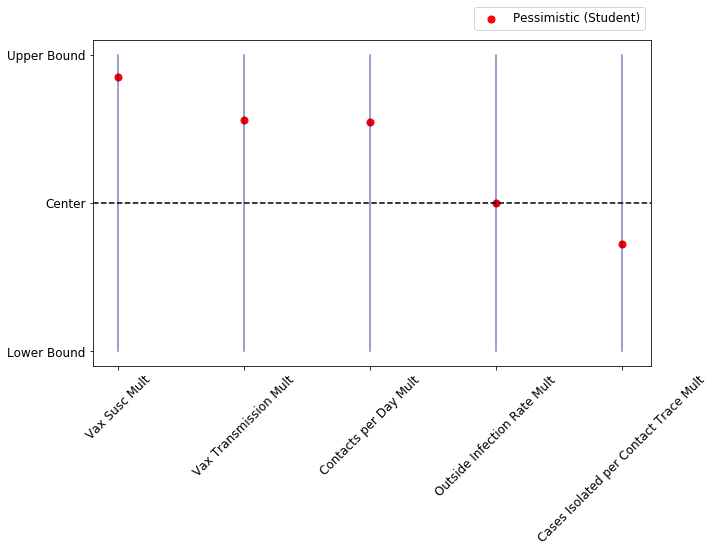

In [8]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, pess_scenario_student[param]), color='red', label='Pessimistic (Student)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, pess_scenario_student[param]), color='red', s=50)

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS))), ['Vax Susc Mult', 'Vax Transmission Mult', 'Contacts per Day Mult',
                                          'Outside Infection Rate Mult', 'Cases Isolated per Contact Trace Mult'])
plt.xticks(rotation = 45)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.ylim(-0.1,1.1)

# plt.xlabel('Parameter')
# plt.ylabel('Value')

legend = plt.legend(frameon = True, loc='upper right', bbox_to_anchor=(1, 1.12))
# frame = legend.get_frame()
# frame.set_color('white')

# plt.legend()
plt.show()

## Pessimistic Scenario Sensitivity Analysis

In [38]:
def get_direction(pess, centre):
    direction = dict()
    for param in centre.keys():
        direction[param] = pess[param] - centre[param]
    return direction

def generate_new_params(centre, direction, mult):
    new_params = dict()
    for param in centre.keys():
        new_params[param] = centre[param] + mult * direction[param]
    return new_params

def launch_sensitivity_analysis(centre, direction, base_folder, mult_list=np.linspace(-1.1, 1.1, 23), nreps=50, param_modifiers=None):

    points = [generate_new_params(centre, direction, mult) for mult in mult_list]

#     folder_name = '{}/{}/'.format(base_folder, 'pess_sensitivity')
#     os.mkdir(folder_name)

#     fnames = [folder_name + 'mult_{}.dill'.format(mult) for mult in mult_list]

    #import pdb; pdb.set_trace()
    processes = run_sims_new_process(points, base_folder, nreps=nreps, param_modifiers=param_modifiers, wait_for_processes_to_join=False)
    return processes


def run_sims_new_process(points, output_folder, nreps=50, T=112, param_modifiers=None, wait_for_processes_to_join=True):
    idx = 0
    processes = []

    base_seed = np.random.randint(1000000, 10000000)

    for point in points:
        idx += 1
        p = run_new_process(point, idx, output_folder, param_modifiers)
        processes.append(p)

    print("launched {} processes".format(len(processes)))
    if wait_for_processes_to_join:
        for p in processes:
            p.join()
        print("done running processes")
        return processes
    else:
        return processes

def run_new_process(point, idx, output_folder, param_modifiers):
    p = Process(target = run_simulations, args = (point, idx, output_folder, param_modifiers))
    p.start()
    return p

def run_simulations(point, idx, output_folder, param_modifiers):
    T=112
    n=50
    if type(point) == dict:
        point = [point['vax_susc_mult'], point['vax_transmission_mult'], point['contacts_per_day_mult'], point['outside_infection_rate_mult'], point['cases_isolated_per_contact_trace']]
    vax_sim = map_lhs_point_to_vax_sim(point, param_modifiers)
    list_of_infs_by_group = run_multiple_trajectories(vax_sim, T, n)
    with open(output_folder + "lhs_point_{}.dill".format(idx), "wb") as f:
        dill.dump(point, f)
    with open(output_folder + "list_of_infs_by_group_{}.dill".format(idx), "wb") as f:
        dill.dump(list_of_infs_by_group, f)

def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre

def get_timestamp():
    return str(time.time()).split('.')[0]

In [64]:
MULT_RANGE = np.linspace(-1.1, 1.1, 23)

# pess_scenario_student
centre = get_centre_point()

direction = get_direction(pess_scenario_student, centre)

# toggle whether/not to use poisson contact tracing
os.environ['use_poisson_contact_tracing'] = 'True'

# base_folder = './aug_31_student_pess_sensitivity_sims_{}/'.format(get_timestamp())
base_folder = './aug_31_student_pess_sensitivity_sims_test_{}/'.format(get_timestamp())
os.mkdir(base_folder)

processes = []

# Test policies: [Vax students freq, Unvax students freq]
# 1: [0, 1/7]
# 2: [0, 2/7]
# 3: [1/7, 1/7]
# 4: [1/7, 2/7]
# 5: [2/7, 2/7]
# Nominal: [1/7, 2/7]

# policy_1_folder = base_folder + 'policy_1/'
# os.mkdir(policy_1_folder)
# test_policy_1 = {'ug_ga_vax_test_frequency': 0/7, 'ug_ga_unvax_test_frequency': 1/7,
#             'ug_other_vax_test_frequency': 0/7, 'ug_other_unvax_test_frequency': 1/7,
#             'grad_vax_test_frequency': 0/7, 'grad_unvax_test_frequency': 1/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_1_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_1))


# policy_2_folder = base_folder + 'policy_2/'
# os.mkdir(policy_2_folder)
# test_policy_2 = {'ug_ga_vax_test_frequency': 0/7, 'ug_ga_unvax_test_frequency': 2/7,
#             'ug_other_vax_test_frequency': 0/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 0/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_2_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_2))


# policy_3_folder = base_folder + 'policy_3/'
# os.mkdir(policy_3_folder)
# test_policy_3 = {'ug_ga_vax_test_frequency': 1/7, 'ug_ga_unvax_test_frequency': 1/7,
#             'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 1/7,
#             'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 1/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_3_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_3))


# policy_4_folder = base_folder + 'policy_4/'
# os.mkdir(policy_4_folder)
# test_policy_4 = {'ug_ga_vax_test_frequency': 1/7, 'ug_ga_unvax_test_frequency': 2/7,
#             'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_4_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_4))


# policy_5_folder = base_folder + 'policy_5/'
# os.mkdir(policy_5_folder)
# test_policy_5 = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
#             'ug_other_vax_test_frequency': 2/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 2/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_5_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_5))


# policy_test = base_folder + 'test_policy/'
# os.mkdir(policy_test)
# test_policy_everyday = {'ug_ga_vax_test_frequency': 1, 'ug_ga_unvax_test_frequency': 1,
#             'ug_other_vax_test_frequency': 1, 'ug_other_unvax_test_frequency': 1,
#             'grad_vax_test_frequency': 1, 'grad_unvax_test_frequency': 1,
#             'employee_vax_test_frequency': 1, 'employee_unvax_test_frequency': 1}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_test, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_everyday))

# policy_6_folder = base_folder + 'policy_6/'
# os.mkdir(policy_6_folder)
# test_policy_6 = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
#             'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_6_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_6))


# policy_7_folder = base_folder + 'policy_7/'
# os.mkdir(policy_7_folder)
# test_policy_7 = {'ug_ga_vax_test_frequency': 3/7, 'ug_ga_unvax_test_frequency': 3/7,
#             'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_7_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_7))


policy_8_folder = base_folder + 'policy_8/'
os.mkdir(policy_8_folder)
test_policy_8 = {'ug_ga_vax_test_frequency': 0/7, 'ug_ga_unvax_test_frequency': 0/7,
            'ug_other_vax_test_frequency': 0/7, 'ug_other_unvax_test_frequency': 0/7,
            'grad_vax_test_frequency': 0/7, 'grad_unvax_test_frequency': 0/7,
            'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
processes.extend(launch_sensitivity_analysis(centre, direction, policy_8_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_8))


# for mult in MULT_RANGE:
#for param in PARAMS_LIST:

print("finished launching processes, waiting for them to finish")
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

launched 23 processes
finished launching processes, waiting for them to finish
0.0 0.4156000000000001


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001
0.0 0.4156000000000001


In [74]:
policy_1_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_1630465754/policy_1', 24, lb=1)
policy_2_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_1630465754/policy_2', 24, lb=1)
policy_3_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_1630465754/policy_3', 24, lb=1)
policy_4_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_1630465754/policy_4', 24, lb=1)
policy_5_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_1630465754/policy_5', 24, lb=1)
policy_6_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_test_1630528206/policy_6', 24, lb=1)
policy_7_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_test_1630617613/policy_7', 24, lb=1)
policy_8_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_student_pess_sensitivity_sims_test_1630690048/policy_8', 24, lb=1)

for df in (policy_1_data, policy_2_data, policy_3_data, policy_4_data, policy_5_data, policy_6_data, policy_7_data, policy_8_data):
    df['mult'] = np.linspace(-1.1, 1.1, 23)
    df['z-score'] = [norm.ppf(0.99) * x for x in np.linspace(-1.1, 1.1, 23)]
    df['quantile'] = [norm.cdf(norm.ppf(0.99) * x) for x in np.linspace(-1.1, 1.1, 23)]

### Cornell Infections

ValueError: x and y must have same first dimension, but have shapes (1,) and (23,)

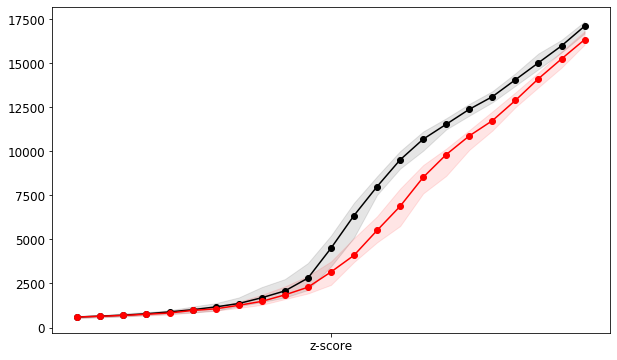

In [67]:
plt.figure(figsize=(10,6))

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_1_data, label='0x/week vax, 1x/week unvax', color='orange')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_1_data, color='orange')

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_2_data, label='0x/week vax, 2x/week unvax', color='green')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_2_data, color='green')

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_3_data, label='1x/week vax, 1x/week unvax', color='blue')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_3_data, color='blue')

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_4_data, label='1x/week vax, 2x/week unvax', color='purple')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_4_data, color='purple')

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_5_data, label='2x/week vax, 2x/week unvax', color='gray')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_5_data, color='gray')

plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_6_data, label='1x/week others, 2x/week greek, unvax', color='black')
plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_6_data, color='black')

plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_7_data, label='3x/week greek, 2x/week unvax, 1x/week vax', color='red')
plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_7_data, color='red')

# plt.plot('z-score', 'cornell_inf_50', marker='o', data=policy_8_data, label='No testing', color='yellow')
# plt.fill_between(x='z-score', y1='cornell_inf_10', y2='cornell_inf_90', alpha=0.1, data=policy_8_data, color='yellow')

plt.title('Student Testing Frequency')
plt.ylabel('Cornell Infections')
plt.xlabel('Pessimism Level')

plt.axvline(norm.ppf(0.99), label='Pessimistic', color='red')
plt.axvline(0, label='Nominal', color='blue')

plotting_quantiles = [0.01, 0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95, 0.99]
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_quantiles)

plt.legend()

plt.show()

### Student Infections

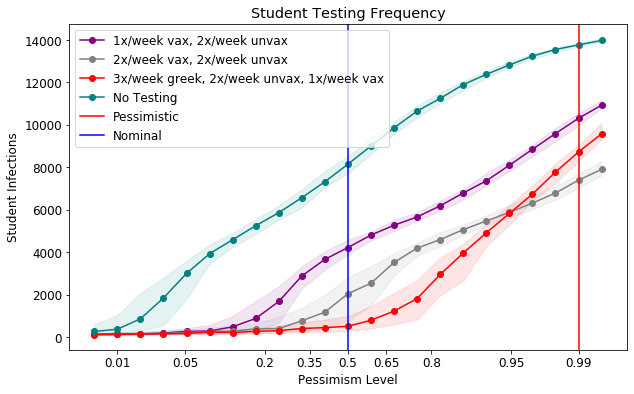

In [77]:
plt.figure(figsize=(10,6))

# plt.plot('z-score', 'student_inf_50', marker='o', data=policy_1_data, label='0x/week vax, 1x/week unvax', color='orange')
# plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_1_data, color='orange')

# plt.plot('z-score', 'student_inf_50', marker='o', data=policy_2_data, label='0x/week vax, 2x/week unvax', color='green')
# plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_2_data, color='green')

# plt.plot('z-score', 'student_inf_50', marker='o', data=policy_3_data, label='1x/week vax, 1x/week unvax', color='blue')
# plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_3_data, color='blue')

plt.plot('z-score', 'student_inf_50', marker='o', data=policy_4_data, label='1x/week vax, 2x/week unvax', color='purple')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_4_data, color='purple')

plt.plot('z-score', 'student_inf_50', marker='o', data=policy_5_data, label='2x/week vax, 2x/week unvax', color='gray')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_5_data, color='gray')

# plt.plot('z-score', 'student_inf_50', marker='o', data=policy_6_data, label='1x/week others, 2x/week greek, unvax', color='black')
# plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_6_data, color='black')

plt.plot('z-score', 'student_inf_50', marker='o', data=policy_7_data, label='3x/week greek, 2x/week unvax, 1x/week vax', color='red')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_7_data, color='red')

plt.plot('z-score', 'student_inf_50', marker='o', data=policy_8_data, label='No Testing', color='teal')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=policy_8_data, color='teal')

plt.title('Student Testing Frequency')
plt.ylabel('Student Infections')
plt.xlabel('Pessimism Level')

plt.axvline(norm.ppf(0.99), label='Pessimistic', color='red')
plt.axvline(0, label='Nominal', color='blue')

plotting_quantiles = [0.01, 0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95, 0.99]
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_quantiles)

plt.legend()

plt.show()

In [25]:
policy_1_data

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,student_inf_10,student_inf_50,student_inf_90,staff_inf_10,staff_inf_50,staff_inf_90,cornell_inf_10,cornell_inf_50,cornell_inf_90,mult,z-score,quantile
0,0.124975,0.393654,1.260772,2.990794,1.150473,123.0,189.5,287.8,436.3,473.5,505.1,589.7,667.0,749.5,-1.1,-2.558983,0.005249
1,0.160832,0.414685,1.309792,2.991631,1.136794,153.8,275.5,437.3,456.2,497.0,547.1,618.6,774.5,929.0,-1.0,-2.326348,0.010000
2,0.196689,0.435717,1.358813,2.992468,1.123114,202.7,343.0,597.3,489.5,541.0,595.2,751.9,865.0,1192.4,-0.9,-2.093713,0.018143
3,0.232545,0.456748,1.407834,2.993305,1.109435,314.0,1075.5,1609.4,522.9,579.5,647.0,893.9,1656.5,2136.0,-0.8,-1.861078,0.031367
4,0.268402,0.477780,1.456855,2.994142,1.095756,684.1,1888.5,2619.2,562.6,644.0,737.1,1357.0,2480.5,3271.6,-0.7,-1.628444,0.051715
5,0.304259,0.498811,1.505875,2.994979,1.082076,2693.1,3086.5,3378.9,667.4,721.0,783.5,3360.6,3810.5,4113.2,-0.6,-1.395809,0.081386
6,0.340116,0.519843,1.554896,2.995816,1.068397,3513.8,3790.0,4092.0,764.9,844.5,960.2,4294.4,4672.0,4914.4,-0.5,-1.163174,0.122379
7,0.375973,0.540874,1.603917,2.996652,1.054717,4354.9,4572.0,4779.9,872.5,1008.5,1139.2,5332.6,5596.5,5808.3,-0.4,-0.930539,0.176046
8,0.411830,0.561906,1.652938,2.997489,1.041038,4901.6,5154.0,5352.9,1003.0,1180.0,1393.2,6063.4,6317.0,6654.9,-0.3,-0.697904,0.242619
9,0.447686,0.582937,1.701958,2.998326,1.027359,5571.4,5815.5,6055.0,1260.2,1537.5,1807.8,7046.7,7300.5,7669.7,-0.2,-0.465270,0.320869


In [ ]:
def load_sim_output(sim_output_files):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS_LIST+\
            ['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90'])

    for fname in sim_output_files:
        with open(fname, 'rb') as fhandle:
            [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS_LIST):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]

        res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
        new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
        new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
        new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]

        scenario_data = scenario_data.append(new_row, ignore_index=True)
    return scenario_data

In [ ]:
def get_direction(pess, centre):
    direction = dict()
    for param in centre.keys():
        direction[param] = pess[param] - centre[param]
    return direction

def generate_new_params(centre, direction, mult):
    new_params = dict()
    for param in centre.keys():
        new_params[param] = centre[param] + mult * direction[param]
    return new_params

def launch_sensitivity_analysis(centre, direction, base_folder, mult_list=np.linspace(-1.1, 1.1, 23), nreps=50):

    points = [generate_new_params(centre, direction, mult) for mult in mult_list]

    folder_name = '{}/{}/'.format(base_folder, 'pess_sensitivity')
    os.mkdir(folder_name)

#     fnames = [folder_name + 'mult_{}.dill'.format(mult) for mult in mult_list]

    #import pdb; pdb.set_trace()
    processes = run_sims_new_process(points, folder_name, nreps=nreps, wait_for_processes_to_join=False)
    return processes


def run_sims_new_process(points, output_folder, nreps=50, T=112, wait_for_processes_to_join=True, test_policy_multipliers=None):
    idx = 0
    processes = []
    if test_policy_multipliers==None:
        test_policy_multipliers = [1] * len(uncertainty_point_dicts)

    base_seed = np.random.randint(1000000, 10000000)

    for point, test_policy_multiplier in zip(points, test_policy_multipliers):
        idx += 1
        p = run_new_process(point, idx, output_folder)
        processes.append(p)

    print("launched {} processes".format(len(processes)))
    if wait_for_processes_to_join:
        for p in processes:
            p.join()
        print("done running processes")
        return processes
    else:
        return processes

def run_new_process(point, idx, output_folder):
    p = Process(target = run_simulations, args = (point, idx, output_folder))
    p.start()
    return p

def run_simulations(lhs_point, idx, output_folder):
    T=112
    n=50
    vax_sim = map_lhs_point_to_vax_sim(point)
    list_of_infs_by_group = run_multiple_trajectories(vax_sim, T, n)
    with open(output_folder + "lhs_point_{}.dill".format(idx), "wb") as f:
        dill.dump(lhs_point, f)
    with open(output_folder + "list_of_infs_by_group_{}.dill".format(idx), "wb") as f:
        dill.dump(list_of_infs_by_group, f)

In [ ]:
def calculate_pessimistic_scenario(results, q=0.99, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']

    invquantile = norm.ppf(q)

    for param in params:
        sd_dict[param] = (PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0])/(2*beta)
        centre_infections += np.mean(PARAM_BOUNDS[param]) * lr_results[param]

    sum_squares_Sigma_1 = 0

    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2

    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)

    mp_pess_scenario = dict()
    for param in params:
        mp_pess_scenario[param] = np.mean(PARAM_BOUNDS[param]) + invquantile * pess_direction[param]

    default_virtual_param_vals = {param:(PARAM_BOUNDS[param][1] + PARAM_BOUNDS[param][0])/2 for param in ADDITIONAL_VIRTUAL_PARAMS}
    for virtual_param, val in default_virtual_param_vals.items():
        if virtual_param not in params:
            mp_pess_scenario[virtual_param] = val

    return mp_pess_scenario

def residential_regression(scenario_data):
    residential_columns = scenario_data.columns[0:12]
    residential_target = 'res_cornell_inf_50'
    X_res = scenario_data[residential_columns]
    Y_res_outcomes = np.array(scenario_data[[residential_target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results

In [ ]:
MULT_RANGE = np.linspace(-1.1, 1.1, 23)

In [ ]:
lhs_output_sim_files = []
for i in range(200):
    fname = '/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630356156.835665\list_of_infs_by_group_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
#res_results = virtual_vs_residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)
centre = get_centre_point()

direction = get_direction(res_pessimistic, centre)

# toggle whether/not to use poisson contact tracing
os.environ['use_poisson_contact_tracing'] = 'True'

base_folder = './jun_23_sims/pess_res_sensitivity_sims_{}/'.format(get_timestamp())
os.mkdir(base_folder)

processes = []

for mult in MULT_RANGE:
#for param in PARAMS_LIST:
    processes.extend(launch_sensitivity_analysis(centre, direction, base_folder, mult_list = MULT_RANGE, nreps=100))

print("finished launching processes, waiting for them to finish")
for p in processes:
    p.join()

In [9]:
with open('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630014533.4721122/list_of_infs_by_group_{}.dill'.format(0), 'rb') as fhandle:
    inf_matrix = np.array(dill.load(fhandle))
    print(inf_matrix, np.sum(inf_matrix[:,:-2], axis=1))
    

[[2027   65  487   16   28    2 4097  516]
 [2274   68  555   11   26    2 5090  751]
 [ 249    4  142    7   16    1 4693  617]
 [1814   57  454   16   26    1 4530  561]
 [1679   37  375   13   32    2 4549  545]
 [2235   61  586   13   30    2 4709  600]
 [2198   59  558   16   20    1 4664  594]
 [1734   42  438   10   32    3 4660  615]
 [2298   65  613   14   24    1 4478  544]
 [1961   46  478   10   40    1 4615  611]
 [1092   24  238    8   19    2 4280  514]
 [1532   30  381   12   38    2 4712  656]
 [2396   71  652   16   26    1 4788  666]
 [1920   61  429    3   33    2 4632  642]
 [1752   39  439   10   42    1 4674  636]
 [1566   45  312    8   27    2 4336  525]
 [1508   27  348    6   25    1 4989  680]
 [1759   53  397    6   17    1 4748  637]
 [2225   71  611   11   30    2 4817  664]
 [1952   45  465   16   26    2 4804  671]
 [1879   49  434   14   24    2 4872  698]
 [ 746   14  205    6   22    2 4794  643]
 [1750   36  437   14   42    2 4371  517]
 [2103   72

In [33]:
i = 7

with open('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630014533.4721122/list_of_infs_by_group_{}.dill'.format(i), 'rb') as fhandle:
    inf_matrix = np.array(dill.load(fhandle))
    infxns = np.sum(inf_matrix[:,:-2], axis=1)
    print(inf_matrix, infxns, np.median(infxns))

with open('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630356156.835665/lhs_point_{}.dill'.format(i), 'rb') as fhandle:
    print(dill.load(fhandle))
#     print(inf_matrix, np.sum(inf_matrix[:,:-2], axis=1))


[[1577   59  323   11   25    2 4789  833]
 [1917   62  461   12   33    3 4983  899]
 [ 986   31  267    9   24    2 4693  827]
 [1636   61  359   14   24    1 5004  894]
 [2576  115  794   23   33    1 4660  768]
 [1403   54  386   12   21    2 4916  936]
 [2014   73  485   17   33    2 5078  944]
 [1193   36  299    8   29    2 4976  871]
 [1534   55  367   12   40    4 4900  923]
 [2251   93  584   22   56    3 4953  905]
 [2264   91  519   21   53    4 5057  953]
 [1839   69  438   16   37    1 4787  808]
 [1150   33  313   16   18    1 4859  869]
 [2337  103  625   22   23    3 4973  944]
 [2046   80  515   18   25    2 4830  803]
 [2554  117  694   19   28    1 4923  874]
 [ 203    5  121    9   19    3 4792  854]
 [1872   75  444   11   35    3 4836  867]
 [1432   52  327   11   20    1 4845  854]
 [1449   44  332   15   14    1 4829  851]
 [ 803   25  224   12   22    1 5114  936]
 [1810   72  419   14   37    2 4857  876]
 [2205   92  618   34   22    1 4802  826]
 [2482  111

In [40]:
def load_sim_output(folder, npoints):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

In [41]:
load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630014533.4721122', 200)

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,student_inf_10,student_inf_50,student_inf_90,staff_inf_10,staff_inf_50,staff_inf_90
0,0.755346,0.585053,1.438668,1.558108,0.780043,1366.4,2290.0,2956.5,4970.8,5273.5,5566.4
1,0.628136,0.841378,2.446465,1.455920,1.260274,5876.3,6133.5,6430.4,6829.0,6966.0,7093.7
2,0.230958,0.710183,0.952408,1.114645,0.628811,81.9,103.0,150.1,279.4,340.0,396.4
3,0.606577,0.462480,2.586425,2.897512,1.001448,3841.4,4293.0,4779.8,6596.3,6706.0,6798.2
4,0.634232,0.369011,1.891846,1.124089,0.959880,360.8,943.0,2018.8,3418.4,4333.5,4964.1
...,...,...,...,...,...,...,...,...,...,...,...
195,0.120707,0.311033,2.420827,4.835813,0.533087,188.7,255.5,337.2,1856.0,2106.0,2444.3
196,0.583199,0.543172,2.304672,2.168524,1.379517,3500.8,4079.0,4510.5,6408.2,6551.0,6650.8
197,0.325682,0.514508,1.024871,1.308345,1.448557,99.0,143.5,226.8,399.3,469.5,547.6
198,0.868993,0.781492,1.818384,3.064451,1.017570,5297.7,5557.0,5783.2,6812.6,6961.0,7075.8


In [31]:
min_dist = 10000
index = None

for i in range(200):
    with open('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630014533.4721122/lhs_point_{}.dill'.format(i), 'rb') as fhandle:
        point = dill.load(fhandle)
#         print(np.array(point), len(point), 0.5 * np.ones(len(point)))
#         print(np.linalg.norm(np.array(point) - 0.5 * np.ones(len(point))))
#         print(np.array(point), np.linalg.norm(point, np.zeros(len(point))))
#     print(np.mean(0.097608, 0.941192), np.mean(0.25, 1), np.mean(0.9,2.7), np.mean(1, 5), np.mean(0.5,1.5))
    dist = np.linalg.norm(point - np.array([np.mean([0.097608, 0.941192]), np.mean([0.25, 1]), np.mean([0.9,2.7]), np.mean([1, 5]), np.mean([0.5,1.5])]))
    print(dist, point)
    if dist < min_dist:
        min_dist = dist
        index = i
        
print(index, min_dist)

with open('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630014533.4721122/lhs_point_{}.dill'.format(index), 'rb') as fhandle:
    point = dill.load(fhandle)
    print(point)


1.5215977553950333 [0.755346   0.58505326 1.43866799 1.55810828 0.78004334]
1.7112816188909223 [0.62813586 0.84137834 2.44646451 1.45592006 1.26027385]
2.1216065336401257 [0.23095799 0.71018305 0.95240789 1.1146445  0.62881057]
0.8142370958218834 [0.60657684 0.46248001 2.58642459 2.89751215 1.00144813]
1.8994216760729727 [0.63423224 0.36901097 1.8918456  1.12408939 0.95987971]
1.8814799894528464 [0.49430289 0.4586745  2.19431018 4.81081644 1.27773405]
0.7675439234992166 [0.13321666 0.66352467 1.87374722 2.46767604 1.38690374]
0.35403812376556393 [0.50445516 0.65493364 1.77376317 2.6760497  0.86364951]
1.3719501036864186 [0.44596375 0.97463113 1.46222326 1.81869542 0.50498622]
0.7996169420918487 [0.38229818 0.43696209 1.0417894  3.00513755 0.8984009 ]
1.1785960128820165 [0.59300838 0.66116277 1.19175715 3.94890161 0.66535243]
1.635022486813308 [0.17106522 0.80099518 0.96145213 1.65742345 0.87625516]
1.760791525175385 [0.25556146 0.70422959 2.45541116 1.40234999 1.20603242]
0.80316301278